# <center> Task 3 : Feature Engineering

---

## 1. Import packages

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---
## 2. Load data

In [173]:
df = pd.read_csv('clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [174]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

In [176]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [177]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [178]:
diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               16096 non-null  object 
 1   offpeak_diff_dec_january_energy  16096 non-null  float64
 2   offpeak_diff_dec_january_power   16096 non-null  float64
dtypes: float64(2), object(1)
memory usage: 377.4+ KB


In [179]:
df = pd.merge(df,diff,on='id')

### Price Trend
Indicates whether prices are increasing, decreasing, or staying constant over time.

In [180]:
price_df['price_trend_off_peak'] = (price_df['price_off_peak_var'].diff() > 0).astype(int)
price_df['price_trend_peak'] = (price_df['price_peak_var'].diff() > 0).astype(int)

In [181]:
price_df['price_trend_peak'].value_counts()

price_trend_peak
0    178358
1     14644
Name: count, dtype: int64

### Price Volatility
Measures the volatility in prices.

In [182]:
price_df['price_volatility_var'] = price_df[['price_off_peak_var', 'price_peak_var']].std(axis=1)
price_df['price_volatility_fix'] = price_df[['price_off_peak_fix', 'price_peak_fix']].std(axis=1)

In [183]:
price_df['price_volatility_var']

0         0.107033
1         0.107033
2         0.107033
3         0.105802
4         0.105802
            ...   
192997    0.012504
192998    0.012504
192999    0.012504
193000    0.012504
193001    0.012504
Name: price_volatility_var, Length: 193002, dtype: float64

### Combing the above 2 measures to the single dataset:

In [184]:
# Group by 'id' and calculate overall mean for trend and standard deviation for volatility
overall_trends = price_df.groupby('id')[['price_trend_off_peak', 'price_trend_peak']].mean().reset_index()
overall_volatility = price_df.groupby('id')[['price_volatility_var', 'price_volatility_fix']].std().reset_index()

In [185]:
overall_volatility

,id,price_volatility_var,price_volatility_fix
0,0002203ffbb812588b632b9e628cc38d,0.001443,1.793642e-02
1,0004351ebdd665e6ee664792efc4fd13,0.001553,6.189463e-02
2,0010bcc39e42b3c2131ed2ce55246e3c,0.018390,5.461643e-01
3,0010ee3855fdea87602a5b7aba8e42de,0.001745,2.406384e-02
4,00114d74e963e47177db89bc70108537,0.001557,4.177864e-07
...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.004055,2.406458e-02
16092,fffac626da707b1b5ab11e8431a4d0a2,0.001484,5.685402e-02
16093,fffc0cacd305dd51f316424bbb08d1bd,0.001516,2.372765e-02
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.001558,2.083935e-02


In [186]:
# Merge the results
updated_pricing_df = pd.merge(overall_trends, overall_volatility, on='id', suffixes=('_trend', '_volatility'))

In [187]:
updated_pricing_df

,id,price_trend_off_peak,price_trend_peak,price_volatility_var,price_volatility_fix
0,0002203ffbb812588b632b9e628cc38d,0.083333,0.166667,0.001443,1.793642e-02
1,0004351ebdd665e6ee664792efc4fd13,0.166667,0.000000,0.001553,6.189463e-02
2,0010bcc39e42b3c2131ed2ce55246e3c,0.250000,0.000000,0.018390,5.461643e-01
3,0010ee3855fdea87602a5b7aba8e42de,0.000000,0.083333,0.001745,2.406384e-02
4,00114d74e963e47177db89bc70108537,0.166667,0.000000,0.001557,4.177864e-07
...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.166667,0.166667,0.004055,2.406458e-02
16092,fffac626da707b1b5ab11e8431a4d0a2,0.166667,0.000000,0.001484,5.685402e-02
16093,fffc0cacd305dd51f316424bbb08d1bd,0.250000,0.166667,0.001516,2.372765e-02
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.000000,0.083333,0.001558,2.083935e-02


## Clean Dataset Feature Engineering

In [188]:
numeric_columns = df.select_dtypes(exclude='object').columns
df['churn'] = df['churn'].replace({'t':1,'f':0})
# Compute the correlation matrix for numeric columns
correlation_matrix = df[numeric_columns].corr()

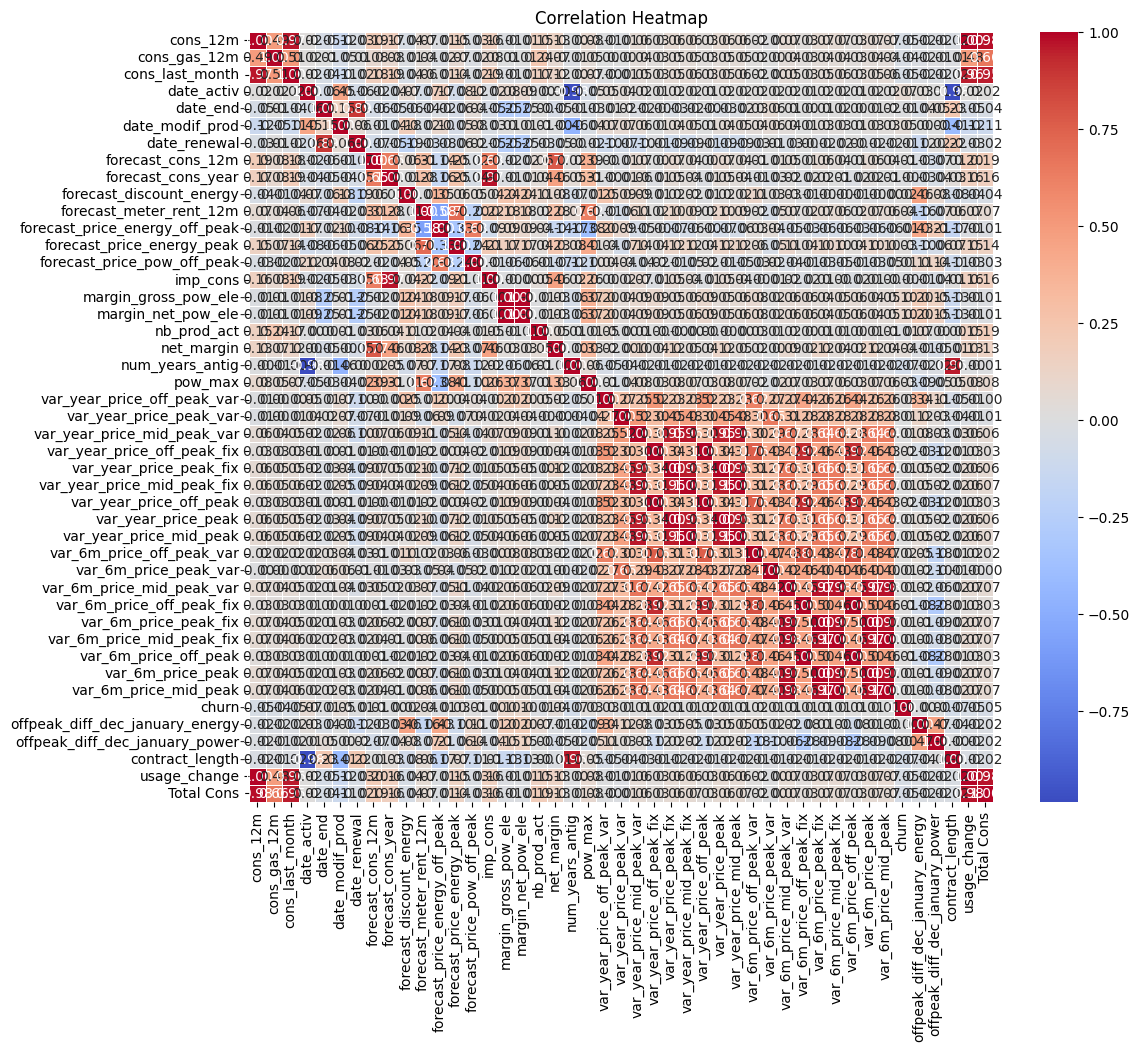

In [107]:
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Contract Length
The length of the contract, which is the time between the activation date (date_activ) and the registered end date (date_end). Longer contract lengths might indicate customer loyalty.

In [189]:
df['contract_length'] = (df['date_end'] - df['date_activ']).dt.days

In [190]:
df['contract_length']

0        1096
1        2566
2        2192
3        2192
4        2245
         ... 
14601    1445
14602    1461
14603    1460
14604    1461
14605    2556
Name: contract_length, Length: 14606, dtype: int64

### Usage Change
Calculating the change in electricity consumption from the past 12 months to the last month.

In [191]:
df['usage_change'] = df['cons_12m'] - df['cons_last_month']

In [192]:
df['usage_change']

0            0
1         4660
2          544
3         1584
4         3899
         ...  
14601    32270
14602     7042
14603     1665
14604      131
14605     8730
Name: usage_change, Length: 14606, dtype: int64

### Total Consumption
Combine information about gas and electricity usage.

In [193]:
df['Total Cons'] = df['cons_gas_12m'] + df['cons_12m']

In [194]:
df[['churn','cons_gas_12m','cons_12m','Total Cons','cons_last_month','usage_change']].corr()

,churn,cons_gas_12m,cons_12m,Total Cons,cons_last_month,usage_change
churn,1.000000,-0.037957,-0.045968,-0.048695,-0.045284,-0.045847
cons_gas_12m,-0.037957,1.000000,0.488474,0.662944,0.507007,0.483946
cons_12m,-0.045968,0.488474,1.000000,0.977104,0.968212,0.999504
Total Cons,-0.048695,0.662944,0.977104,1.000000,0.954348,0.975574
cons_last_month,-0.045284,0.507007,0.968212,0.954348,1.000000,0.959858
usage_change,-0.045847,0.483946,0.999504,0.975574,0.959858,1.000000


### One-Hot Encoding
To convert categorical features to numerical features

In [195]:
df['has_gas'] = df['has_gas'].replace({'t':1,'f':0})

In [196]:
# Assuming 'client_df' is your DataFrame
df = pd.get_dummies(df, columns=['channel_sales', 'origin_up'], drop_first=True,dtype='int')

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   id                                              14606 non-null  object        
 1   cons_12m                                        14606 non-null  int64         
 2   cons_gas_12m                                    14606 non-null  int64         
 3   cons_last_month                                 14606 non-null  int64         
 4   date_activ                                      14606 non-null  datetime64[ns]
 5   date_end                                        14606 non-null  datetime64[ns]
 6   date_modif_prod                                 14606 non-null  datetime64[ns]
 7   date_renewal                                    14606 non-null  datetime64[ns]
 8   forecast_cons_12m                             

## Dropping Irrelevant Columns

In [198]:
df[['margin_gross_pow_ele', 'margin_net_pow_ele','net_margin','pow_max']].describe()

,margin_gross_pow_ele,margin_net_pow_ele,net_margin,pow_max
count,14606.000000,14606.000000,14606.000000,14606.000000
mean,24.565121,24.562517,189.264522,18.135136
std,20.231172,20.230280,311.798130,13.534743
min,0.000000,0.000000,0.000000,3.300000
25%,14.280000,14.280000,50.712500,12.500000
50%,21.640000,21.640000,112.530000,13.856000
75%,29.880000,29.880000,243.097500,19.172500
max,374.640000,374.640000,24570.650000,320.000000


In [199]:
df[['margin_gross_pow_ele', 'margin_net_pow_ele','net_margin','churn']].corr()

,margin_gross_pow_ele,margin_net_pow_ele,net_margin,churn
margin_gross_pow_ele,1.000000,0.999914,0.031814,0.095725
margin_net_pow_ele,0.999914,1.000000,0.031639,0.095772
net_margin,0.031814,0.031639,1.000000,0.041135
churn,0.095725,0.095772,0.041135,1.000000


In [200]:
drop_col = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal',
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak',
    'margin_gross_pow_ele',
    'margin_net_pow_ele',
    'net_margin'
]

In [201]:
df = df.drop(columns=drop_col)

## Combining Customer Dataset with Updated Pricing Dataset

In [202]:
updated_pricing_df

,id,price_trend_off_peak,price_trend_peak,price_volatility_var,price_volatility_fix
0,0002203ffbb812588b632b9e628cc38d,0.083333,0.166667,0.001443,1.793642e-02
1,0004351ebdd665e6ee664792efc4fd13,0.166667,0.000000,0.001553,6.189463e-02
2,0010bcc39e42b3c2131ed2ce55246e3c,0.250000,0.000000,0.018390,5.461643e-01
3,0010ee3855fdea87602a5b7aba8e42de,0.000000,0.083333,0.001745,2.406384e-02
4,00114d74e963e47177db89bc70108537,0.166667,0.000000,0.001557,4.177864e-07
...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.166667,0.166667,0.004055,2.406458e-02
16092,fffac626da707b1b5ab11e8431a4d0a2,0.166667,0.000000,0.001484,5.685402e-02
16093,fffc0cacd305dd51f316424bbb08d1bd,0.250000,0.166667,0.001516,2.372765e-02
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.000000,0.083333,0.001558,2.083935e-02


In [204]:
combined_df = pd.merge(df,updated_pricing_df,on='id')

In [205]:
combined_df

,id,has_gas,imp_cons,nb_prod_act,num_years_antig,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,...,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_ewxeelcelemmiwuafmddpobolfuxioce,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,origin_up_usapbepcfoloekilkwsdiboslwaxobdp,price_trend_off_peak,price_trend_peak,price_volatility_var,price_volatility_fix
0,24011ae4ebbe3035111d65fa7c15bc57,1,0.00,2,3,43.648,0.000061,2.627605e-05,4.402763e-04,1.102785e+00,...,0,0,0,0,1,0,0.083333,0.166667,0.008293,5.717751e+00
1,d29c2c54acc38ff3c0614d0a653813dd,0,0.00,1,6,13.800,0.000005,6.089453e-04,0.000000e+00,6.464779e-03,...,0,0,1,0,0,0,0.166667,0.083333,0.018295,5.685411e-02
2,764c75f661154dac3a6c254cd082ea7d,0,0.00,1,6,13.856,0.000006,2.558511e-07,0.000000e+00,7.661891e-03,...,0,0,1,0,0,0,0.083333,0.166667,0.001726,6.189463e-02
3,bba03439a292a1e166f80264c16191cb,0,0.00,1,6,13.200,0.000005,0.000000e+00,0.000000e+00,6.464721e-03,...,0,0,1,0,0,0,0.083333,0.000000,0.001638,5.685385e-02
4,149d57cf92fc41cf94415803a877cb4b,0,52.32,1,6,19.800,0.000015,3.552481e-06,2.522046e-06,5.428942e-03,...,0,0,1,0,0,0,0.083333,0.166667,0.001438,2.084023e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,1,0.00,2,4,15.000,0.000015,0.000000e+00,0.000000e+00,8.380216e-03,...,0,0,0,0,1,0,0.166667,0.000000,0.002755,6.473104e-02
14602,d0a6f71671571ed83b2645d23af6de00,0,15.94,1,3,6.000,0.000013,3.472391e-06,1.638788e-08,1.358132e-02,...,0,0,0,0,1,0,0.000000,0.000000,0.001278,3.158708e-02
14603,10e6828ddd62cbcf687cb74928c4c2d2,0,18.05,1,4,15.935,0.000016,3.957295e-06,1.871602e-06,4.021438e-03,...,0,0,0,0,1,0,0.166667,0.166667,0.001443,1.793642e-02
14604,1cf20fd6206d7678d5bcafd28c53b4db,0,0.00,1,3,11.000,0.000005,6.089453e-04,0.000000e+00,6.464769e-03,...,0,0,0,0,1,0,0.166667,0.083333,0.018295,5.685406e-02


In [206]:
combined_df.to_csv("Train.csv",index=False)